# FSRS to Anki SM-2

Click on the button below to open this notebook in Google Colab

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kuroahna/anki_srs_kai/blob/main/fsrs_to_sm2.ipynb)

In [1]:
%pip install --quiet fsrs==6.1.1

Modify the values below

In [2]:
# Replace with your optimized parameters
parameters = [0.212, 1.2931, 2.3065, 8.2956, 6.4133, 0.8334, 3.0194, 0.001, 1.8722, 0.1666, 0.796, 1.4835, 0.0614, 0.2629, 1.6483, 0.6014, 1.8729, 0.5425, 0.0912, 0.0658, 0.1542]
# Set this to the same value as the Starting Ease in your deck
starting_ease = 2.5
# Replace with your desired retention
desired_retention = 0.90

In Google Colab
1. Click on the **Runtime** button in the toolbar at the top
2. Click on the **Run all** button

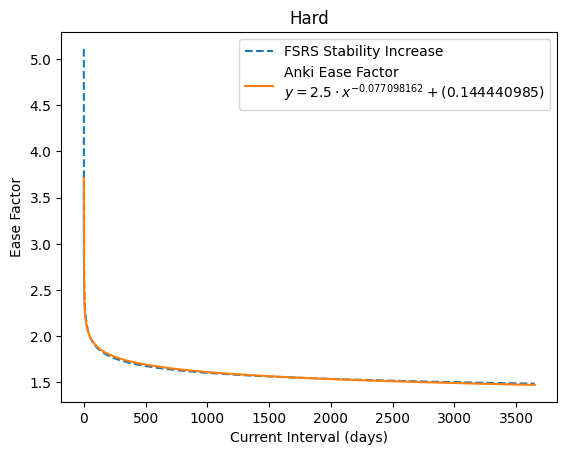


    Lower error values is better. RMSE provides better insight in how well the
    Anki Ease Factor function fits to the FSRS Stability Increase function than
    MSE and MAE

    Mean Squared Error (MSE): 0.000205343
    Mean Absolute Error (MAE): 0.008794683
    Root Mean Squared Error (RMSE): 0.014329807
    


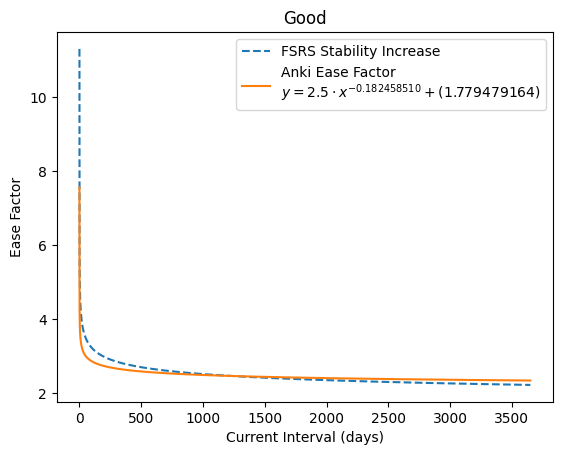


    Lower error values is better. RMSE provides better insight in how well the
    Anki Ease Factor function fits to the FSRS Stability Increase function than
    MSE and MAE

    Mean Squared Error (MSE): 0.020203949
    Mean Absolute Error (MAE): 0.094757716
    Root Mean Squared Error (RMSE): 0.142140595
    


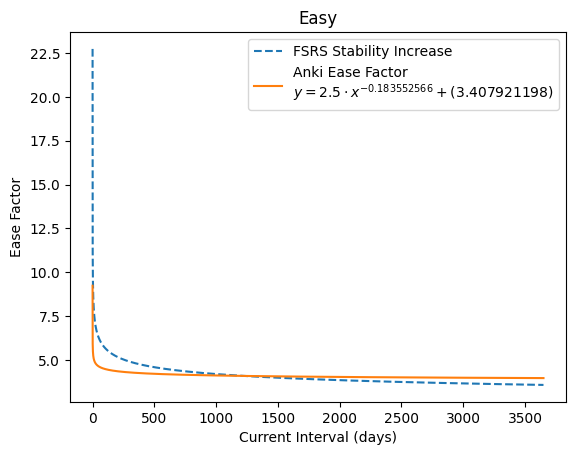


    Lower error values is better. RMSE provides better insight in how well the
    Anki Ease Factor function fits to the FSRS Stability Increase function than
    MSE and MAE

    Mean Squared Error (MSE): 0.224196130
    Mean Absolute Error (MAE): 0.312236251
    Root Mean Squared Error (RMSE): 0.473493538
    

Replace your settings in the Deck Options for your deck with the values below.
Note:
1. Use `Graduating interval (good)` if you often press Good when first learning
   a new card
2. Otherwise, use `Graduating interval (hard)` if you often press Hard when
   first learning a new card
3. Otherwise, use `Graduating interval (again)` if you often press Again when
   first learning a new card
4. If you're not sure, use `Graduating interval (good)`
This is because FSRS considers the first rating for New cards when training its
parameters. Since Anki SM-2 does not consider the first rating for New cards, it
is best to set the Graduating interval to the one you most often use


Gradu

In [3]:
from datetime import datetime
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from typing import List

import copy
import fsrs
import matplotlib.pyplot as plt
import numpy as np


scheduler = fsrs.Scheduler(
    parameters = parameters,
    desired_retention = desired_retention,
    maximum_interval = 1_000_000,
)


def fsrs_stability_increase(
    x_data: List[float],
    difficulty: float,
    retrievability: float,
    rating: fsrs.Rating
):
    return [
        scheduler._next_recall_stability(difficulty=difficulty, stability=x, retrievability=retrievability, rating=rating) / x
        for x in x_data
    ]


def anki_ease_factor(x: List[float], a: float, b: float):
    return starting_ease * x ** a + b



x_data = np.linspace(0.01, 3650, 100000)



def fit_data(
    x_data: List[float],
    rating: fsrs.Rating
):
    # Set retrievability to 0.90 because when converting to Anki SM-2, we need
    # to assume that the intervals have 90% retrievability
    retrievability = 0.90
    difficulty = scheduler._initial_difficulty(rating=rating)
    y_data = fsrs_stability_increase(x_data, difficulty, retrievability, rating)
    params, _ = curve_fit(anki_ease_factor, x_data, y_data)

    y_approx = anki_ease_factor(x_data, *params)
    mse = mean_squared_error(y_data, y_approx)
    mae = mean_absolute_error(y_data, y_approx)
    rmse = np.sqrt(mse)

    return (params, y_data, y_approx, mse, mae, rmse)


hard_params, hard_y_data, hard_y_approx, hard_mse, hard_mae, hard_rmse = fit_data(x_data, fsrs.Rating.Hard)
good_params, good_y_data, good_y_approx, good_mse, good_mae, good_rmse = fit_data(x_data, fsrs.Rating.Good)
easy_params, easy_y_data, easy_y_approx, easy_mse, easy_mae, easy_rmse = fit_data(x_data, fsrs.Rating.Easy)


def plot_data(title: str, x_data: List[float], y_data: List[float], y_approx: List[float], params: List[float], mse: float, mae: float, rmse: float):
    plt.title(title)
    plt.plot(x_data, y_data, label="FSRS Stability Increase", linestyle="dashed")
    plt.plot(
        x_data,
        y_approx,
        label=f"Anki Ease Factor\n$y = {starting_ease} \\cdot x^{{{params[0]:.9f}}} + ({params[1]:.9f})$"
    )
    plt.legend()
    plt.xlabel("Current Interval (days)")
    plt.ylabel("Ease Factor")
    plt.show()

    print(f"""
    Lower error values is better. RMSE provides better insight in how well the
    Anki Ease Factor function fits to the FSRS Stability Increase function than
    MSE and MAE

    Mean Squared Error (MSE): {mse:.9f}
    Mean Absolute Error (MAE): {mae:.9f}
    Root Mean Squared Error (RMSE): {rmse:.9f}
    """)

plot_data("Hard", x_data, hard_y_data, hard_y_approx, hard_params, hard_mse, hard_mae, hard_rmse)
plot_data("Good", x_data, good_y_data, good_y_approx, good_params, good_mse, good_mae, good_rmse)
plot_data("Easy", x_data, easy_y_data, easy_y_approx, easy_params, easy_mse, easy_mae, easy_rmse)

copy_scheduler = copy.deepcopy(scheduler)
copy_scheduler.maximum_interval = scheduler.maximum_interval * 2
interval_modifier = copy_scheduler._next_interval(stability=scheduler.maximum_interval) / scheduler.maximum_interval

graduating_interval_again = scheduler._initial_stability(rating=fsrs.Rating.Again) * interval_modifier
graduating_interval_hard = scheduler._initial_stability(rating=fsrs.Rating.Hard) * interval_modifier
graduating_interval_good = scheduler._initial_stability(rating=fsrs.Rating.Good) * interval_modifier
easy_interval = scheduler._initial_stability(rating=fsrs.Rating.Easy) * interval_modifier
print(f"""
Replace your settings in the Deck Options for your deck with the values below.
Note:
1. Use `Graduating interval (good)` if you often press Good when first learning
   a new card
2. Otherwise, use `Graduating interval (hard)` if you often press Hard when
   first learning a new card
3. Otherwise, use `Graduating interval (again)` if you often press Again when
   first learning a new card
4. If you're not sure, use `Graduating interval (good)`
This is because FSRS considers the first rating for New cards when training its
parameters. Since Anki SM-2 does not consider the first rating for New cards, it
is best to set the Graduating interval to the one you most often use


Graduating interval (again): {graduating_interval_again:.0f}
Graduating interval (hard): {graduating_interval_hard:.0f}
Graduating interval (good): {graduating_interval_good:.0f}
Easy interval: {easy_interval:.0f}


Replace the scheduler settings for your deck in the Custom scheduling field in
the Deck Options with the following values:


scheduler: {{
    // ... (other settings)
    intervalModifier: {interval_modifier},
    calculateHardMultiplier: (currentEaseFactor, currentInterval) => {{
        return currentEaseFactor * Math.pow(currentInterval, {hard_params[0]:.9f}) + ({hard_params[1]:.9f});
    }},
    calculateGoodMultiplier: (currentEaseFactor, currentInterval) => {{
        return currentEaseFactor * Math.pow(currentInterval, {good_params[0]:.9f}) + ({good_params[1]:.9f});
    }},
    calculateEasyMultiplier: (currentEaseFactor, currentInterval) => {{
        return currentEaseFactor * Math.pow(currentInterval, {easy_params[0]:.9f}) + ({easy_params[1]:.9f});
    }},
}},

""")